<a href="https://colab.research.google.com/github/fathanzys/Data/blob/main/UAS_Datamining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Klasifikasi Kategori BMI dan Rekomendasi Profil Diet Harian Berdasarkan Data NHANES**

#**1. Import Library**

###**1.1 Import Library**

In [60]:
# 1. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

###**1.2 Load Dataset**

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
demographic_data = pd.read_csv("/content/drive/MyDrive/DM/uas/demographic.csv", encoding="latin1")
diet_data = pd.read_csv("/content/drive/MyDrive/DM/uas/diet.csv", encoding="latin1")
examination_data = pd.read_csv("/content/drive/MyDrive/DM/uas/examination.csv", encoding="latin1")
labs_data = pd.read_csv("/content/drive/MyDrive/DM/uas/labs.csv", encoding="latin1")
medications_data = pd.read_csv("/content/drive/MyDrive/DM/uas/medications.csv", encoding="latin1")
questionnaire_data = pd.read_csv("/content/drive/MyDrive/DM/uas/questionnaire.csv", encoding="latin1")

###**1.3 Merge Dataset**

In [63]:
df = demographic_data[['SEQN', 'RIDAGEYR', 'RIAGENDR']]
df = df.merge(diet_data[['SEQN', 'DR1TKCAL', 'DR1TSUGR']], on='SEQN', how='inner')
df = df.merge(examination_data[['SEQN', 'BMXBMI', 'BMXWT', 'BMXHT']], on='SEQN', how='inner')
df = df.merge(labs_data[['SEQN', 'LBXSGL']], on='SEQN', how='inner')
df = df.merge(questionnaire_data[['SEQN', 'BPQ020']], on='SEQN', how='inner')

#**2. Data Preprocessing**

###**2.1. Data Cleaning**

In [64]:
df = df.dropna()
df['BPQ020'] = df['BPQ020'].replace({2: 0})


###**2.2. Kategori BMI**

In [65]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'
df['BMI_Category'] = df['BMXBMI'].apply(categorize_bmi)

###**2.3 Feature Mapping**

In [67]:
# 5. Mapping nama fitur ke panjang
feature_map = {
    'RIDAGEYR': 'Age (years)',
    'RIAGENDR': 'Gender (1=Male, 2=Female)',
    'DR1TKCAL': 'Total Calorie Intake (kcal)',
    'DR1TSUGR': 'Sugar Intake (g)',
    'BMXWT': 'Weight (kg)',
    'BMXHT': 'Height (cm)',
    'LBXSGL': 'Fasting Glucose (mg/dL)',
    'BPQ020': 'Diagnosed with Hypertension (1=Yes, 0=No)'
}
df.rename(columns=feature_map, inplace=True)

#**3. Data Transformation**

###**3.1. Feature & Target**

In [68]:
X = df[list(feature_map.values())]
y = df['BMI_Category']

###**3.2. Scaling dan Split**

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

###**3.3 SMOTE**

In [70]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#**4. Data Mining**

###**4.1 Random Forest**

In [71]:
# 9. Random Forest
clf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

#**5. Evaluation**

###**5.1 Classification Report**

In [74]:
print("Classification Report: ")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report: 
              precision    recall  f1-score   support

      Normal       0.93      0.91      0.92       328
       Obese       0.96      0.94      0.95       391
  Overweight       0.87      0.90      0.89       336
 Underweight       0.62      0.80      0.70        20

    accuracy                           0.92      1075
   macro avg       0.85      0.89      0.86      1075
weighted avg       0.92      0.92      0.92      1075

Accuracy: 0.9153488372093024


###**5.2 Confussion Matrix**

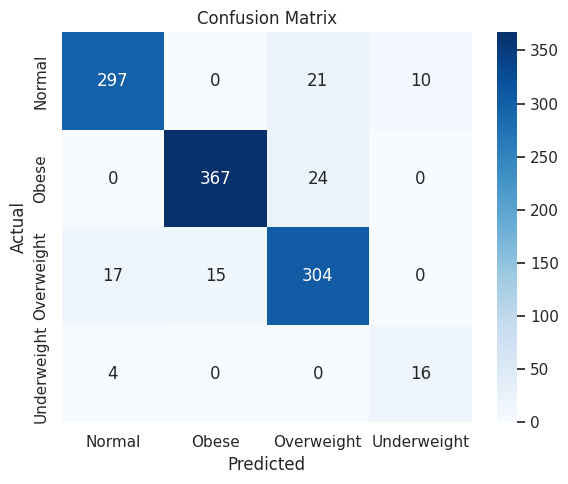

In [75]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

###**5.3 Feature Important**

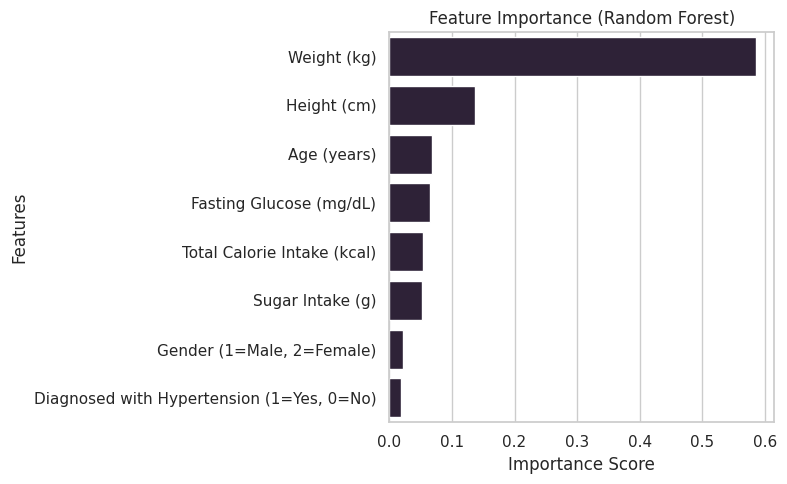

In [76]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=np.array(list(feature_map.values()))[indices])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

###**5.4 Classification Report Heatmap**

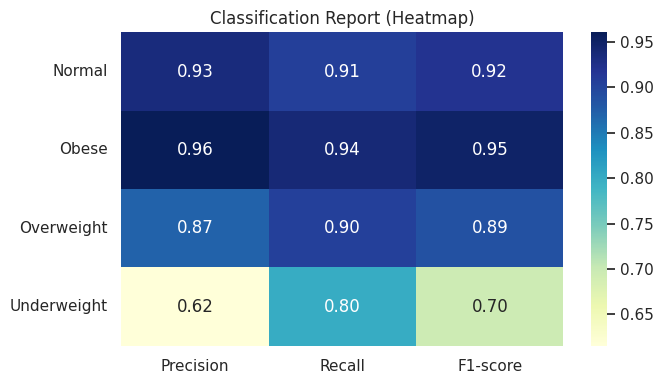

In [77]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=clf.classes_)
report_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-score': f1}, index=clf.classes_)
plt.figure(figsize=(7, 4))
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Classification Report (Heatmap)")
plt.tight_layout()
plt.show()

#**6. Visualisasi/Knowledge Presentation**

###**6.1 Pola Diet**

In [78]:
diet_summary = df.groupby('BMI_Category')[
    ['Total Calorie Intake (kcal)', 'Sugar Intake (g)']
].agg(['mean', 'std', 'median', 'min', 'max'])
print("Ringkasan Pola Diet per Kategori BMI")
print(diet_summary)

=== Ringkasan Pola Diet per Kategori BMI ===
             Total Calorie Intake (kcal)                                       \
                                    mean          std  median    min      max   
BMI_Category                                                                    
Normal                       2145.435366  1083.941714  1931.0  360.0  11361.0   
Obese                        2078.475435   993.944114  1916.5  117.0  12108.0   
Overweight                   2141.163192  1013.961087  1981.0  217.0  10293.0   
Underweight                  2236.558824  1018.691809  2122.0  630.0   6805.0   

             Sugar Intake (g)                                    
                         mean        std  median   min      max  
BMI_Category                                                     
Normal             112.862909  83.121628  94.565  0.61  1115.50  
Obese              111.423690  78.659210  95.675  0.13   835.70  
Overweight         109.993228  75.269108  93.360  0.38   

###**6.2 Distribusi Kalori dan Gula**

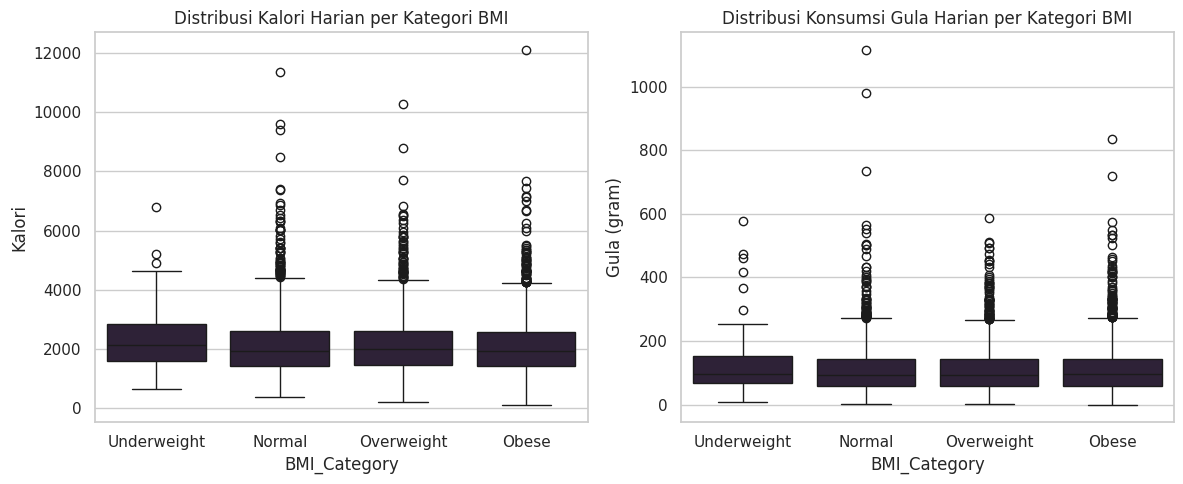

In [79]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='BMI_Category', y='Total Calorie Intake (kcal)', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'])
plt.title("Distribusi Kalori Harian per Kategori BMI")
plt.ylabel("Kalori")
plt.subplot(1, 2, 2)
sns.boxplot(x='BMI_Category', y='Sugar Intake (g)', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'])
plt.title("Distribusi Konsumsi Gula Harian per Kategori BMI")
plt.ylabel("Gula (gram)")
plt.tight_layout()
plt.show()

###**6.3 Korelasi BMI & Kalori**

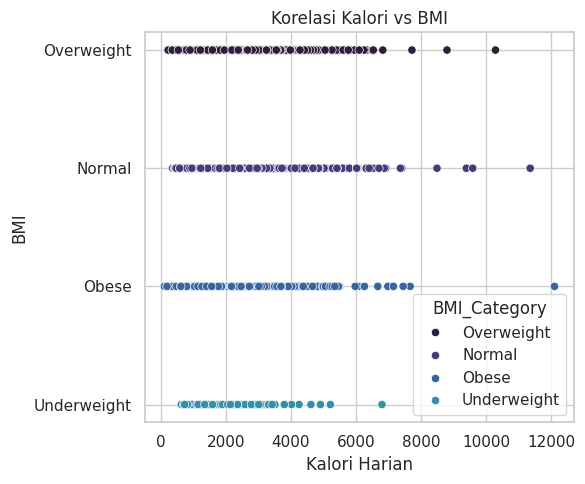

In [80]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x='Total Calorie Intake (kcal)', y='BMI_Category', hue='BMI_Category', data=df)
plt.title("Korelasi Kalori vs BMI")
plt.xlabel("Kalori Harian")
plt.ylabel("BMI")
plt.tight_layout()
plt.show()

###**6.4 Rata-rata Profile Diet**

In [81]:
selected_features = ['Total Calorie Intake (kcal)', 'Sugar Intake (g)', 'Fasting Glucose (mg/dL)']
diet_profile = df.groupby('BMI_Category')[selected_features].mean().round(2)
print("Profil Diet Rekomendasi Harian (Rata-rata)")
display(diet_profile)

Profil Diet Rekomendasi Harian (Rata-rata)


,Total Calorie Intake (kcal),Sugar Intake (g),Fasting Glucose (mg/dL)
BMI_Category,,,
Normal,2145.44,112.86,93.45
Obese,2078.48,111.42,110.72
Overweight,2141.16,109.99,102.96
Underweight,2236.56,122.39,91.09


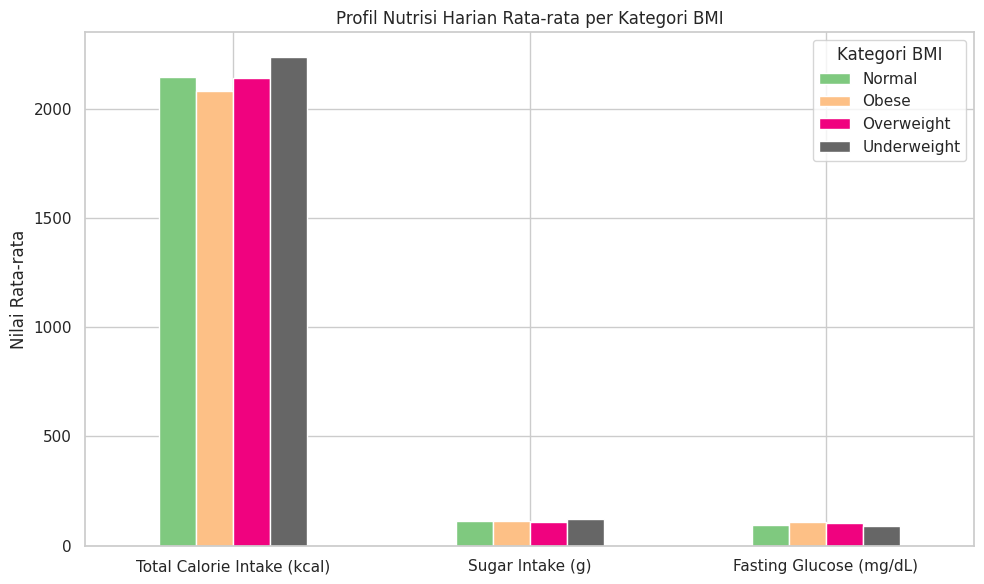

In [82]:
diet_profile.T.plot(kind='bar', figsize=(10, 6), colormap='Accent')
plt.title("Profil Nutrisi Harian Rata-rata per Kategori BMI")
plt.ylabel("Nilai Rata-rata")
plt.xticks(rotation=0)
plt.legend(title="Kategori BMI")
plt.tight_layout()
plt.show()

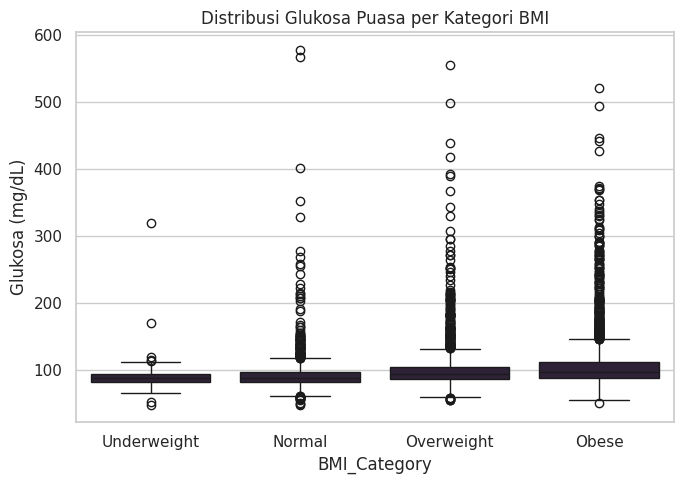

In [94]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='BMI_Category', y='Fasting Glucose (mg/dL)', data=df, order=['Underweight', 'Normal', 'Overweight', 'Obese'])
plt.title("Distribusi Glukosa Puasa per Kategori BMI")
plt.ylabel("Glukosa (mg/dL)")
plt.tight_layout()
plt.show()